<a href="https://colab.research.google.com/github/bhavya0324/CS5691/blob/main/Adaboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AdaBoost

Let us implement the AdaBoost algorithm, to build a powerful emsemble classifier from a set of weaker classifiers. Our base classifier will be a decision stump.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The training algorithm we will implement is as follows. We have $N$ training datapoints and are creating an ensemble of $k$ classifiers.

- Initialize the weights for all datapoints ($w_j = 1/N$ for $j=1,2,...N$)
- For $i = 1$ to $k$
    - Form training set $D_i$ by sampling $N$ tuples (with replacement) from the full training dataset. The sampling probability for a tuple $(x_j,y_j)$ should be given by its corresponding weight $w_j$.
    - Use dataset $D_i$ to fit a decision stump $M_i$. You can use sklearn's DecisionTreeClassifier with max_depth=1 to fit a decision stump.
    - Calculate the error rate for $M_i$ using the sum of the weights of the misclassified points.
    $$err(M_i) = \sum_{j=1}^N w_j * \mathbb{1}\{y_j \ne M_i(x_j)\}$$
    - The weight of classifier $M_i$'s vote is computed as $\alpha_i = 0.5*\log(\frac{1-err(M_i)}{err(M_i)})$
    - Increase the weight of the misclassified training points, and decrease the weight of the correctly classified training points.
    $$w_j \leftarrow w_j * \exp\{- \alpha_i * y_j * M_i(x_j)\}$$
    - Remember to normalize the weights so that they sum to 1.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Import the libraries / functions that you use in your solution
from random import sample
import random
from math import log,exp
from sklearn.tree import DecisionTreeClassifier
def setSeed():
    np.random.seed(11)
def train_AdaBoost(X, y, k):
    setSeed()
    classifiers = []
    alphas = []
    
    ### BEGIN SOLUTION
    
    N = X.shape[0]
    D = pd.DataFrame(columns=['x1','x2','Label','prob'])
    D['x1']=X.iloc[:,0]
    D['x2']=X.iloc[:,1]
    D['Label']=y

    
    # Initialize weights
    D['prob'] =1/N
    for i in range(k):
        
        # Sample from the dataset according to weights 
        sample_1 = D.sample(len(D), replace = True, weights = D['prob'])
        sample_1=sample_1.iloc[:,0:3]
        X_sampled = sample_1.iloc[:,0:2]
        y_sampled = sample_1.iloc[:,2]

        # Fit a decision stump 
        clf_gini = DecisionTreeClassifier(criterion = "gini", max_depth=1, random_state=42)
        clf_gini.fit(X_sampled, y_sampled)
        y_pred = clf_gini.predict(D.iloc[0:len(D),0:2])
        D['pred'] = y_pred
        
        # Calculate the error rate
        D.loc[D.Label != D.pred, 'misclassified'] = 1
        D.loc[D.Label == D.pred, 'misclassified'] = 0
        e = sum(D['misclassified'] * D['prob'])

        # Calculate the weight of classifier's vote
        alpha = 0.5*log((1-e)/e)
            
        # Increase the weight of misclassified points
        new_weight = D['prob']*np.exp(-1*alpha*D['Label']*D['pred'])
        normalized_weight = new_weight/sum(new_weight)
        D['prob'] = round(normalized_weight,4)

        
        # Append your classifier to the list classifiers
        classifiers.append(clf_gini)
        
        # Append your alpha to the list alphas
        alphas.append(alpha)
        
    ### END SOLUTION
    
    # classifiers and alphas need of be of type <class 'list'>
    return classifiers, alphas

To obtain predictions, the vote of each classifier $M_i$ is weighted by its corresponding coefficient $\alpha_i$.

$$y_i = \text{sign}\{\sum_{i=1}^k \alpha_i*M_i(x_i)\}$$

In [ ]:
def predict_AdaBoost(X,classifiers, alphas):
    
    ### BEGIN SOLUTION
    classifier_preds = np.array([classifier.predict(X) for classifier in classifiers])
    y_pred= np.sign(np.dot(alphas, classifier_preds))
    ### END SOLUTION
    
    # y_pred needs to be of type <class 'numpy.ndarray'>
    return y_pred

The below function will help you plot the decision surface given by the algorithm.

In [ ]:
def plot_AdaBoost(X, y, classifiers, alphas):
    
    # Get limits of x and y for plotting the decision surface
    x_min, x_max = X.iloc[:, 0].min() - .5, X.iloc[:, 0].max() + .5
    y_min, y_max = X.iloc[:, 1].min() - .5, X.iloc[:, 1].max() + .5
    
    # Get points at a distance of h between the above limits 
    h = .02    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    temp = np.c_[xx.ravel(), yy.ravel()]
    
    # Classify the all the points
    P = predict_AdaBoost(temp, classifiers, alphas).reshape(yy.shape)
    
    # Plot the decision boundary and margin
    plt.pcolormesh(xx, yy, P, cmap=plt.cm.coolwarm, shading='auto')
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.coolwarm,edgecolor='k')
    plt.title("test data with learnt decision surface")
    plt.show()

Load the given datasets.

In [ ]:
x_train=pd.read_csv("/content/drive/MyDrive/PRML/IITM/Question2/X_train.csv",names=['x1','x2'])
x_test=pd.read_csv("/content/drive/MyDrive/PRML/IITM/Question2/X_test.csv",names=['x1','x2'])
y_train=pd.read_csv("/content/drive/MyDrive/PRML/IITM/Question2/y_train.csv",names=['Label'])
y_test=pd.read_csv("/content/drive/MyDrive/PRML/IITM/Question2/y_test.csv",names=['Label'])

Plot the training data as a scatter plot.

Text(0, 0.5, 'y')

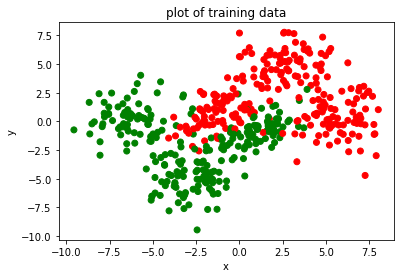

In [ ]:
c = y_train.Label.values
color= ['red' if c == -1 else 'green' for c in c]
plt.scatter(x_train.iloc[:, 0],x_train.iloc[:, 1],color=color)
plt.title("plot of training data")
plt.xlabel("x")
plt.ylabel("y")

Use the train_AdaBoost function to train an AdaBoost model with k=5.

In [ ]:
classifiers,alpha=train_AdaBoost(x_train,y_train,5)

Use the predict_AdaBoost function to make predictions on X_test.

In [ ]:
y_pred=predict_AdaBoost(x_test,classifiers,alpha)

Use the plot_AdaBoost function to plot the learnt decision surface.

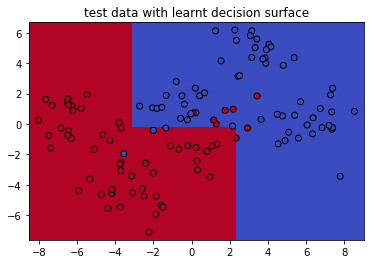

In [ ]:
plot_AdaBoost(x_test,y_test.iloc[:,0],classifiers,alpha)

Compute the accuracy of the predictions on the test set.

Accuracy on TestData 0.9166666666666666


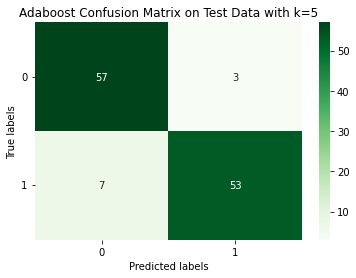

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix
def print_con_matrix(y,test_data_predictions):
        cm_svm =  confusion_matrix(y, test_data_predictions)

        ax = plt.subplot()
        import seaborn as sns
        sns.heatmap(cm_svm, annot=True, ax = ax, fmt='g', cmap='Greens') 

        # Labels, title and ticks
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels') 
        ax.set_title('Adaboost Confusion Matrix on Test Data with k=5') 
        labels = [0, 1]
        ax.xaxis.set_ticklabels(labels) 
        ax.yaxis.set_ticklabels(labels, rotation=360);

accuracy = accuracy_score(y_test.iloc[:,0],y_pred)
print("Accuracy on TestData",accuracy)
print_con_matrix(y_test.iloc[:,0],y_pred)

Use the train_AdaBoost function to train an AdaBoost model with k=100.

In [ ]:
classifiers_100,alpha_100=train_AdaBoost(x_train,y_train,100)

Use the predict_AdaBoost function to make predictions on X_test.

In [ ]:
y_pred=predict_AdaBoost(x_test,classifiers_100,alpha_100)

Use the plot_AdaBoost function to plot the learnt decision surface.

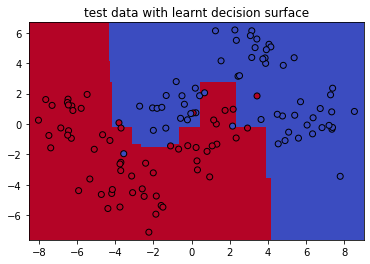

In [ ]:
plot_AdaBoost(x_test,y_test.iloc[:,0],classifiers_100,alpha_100)

Compute the accuracy of the predictions on the test set.

Accuracy on TestData 0.95


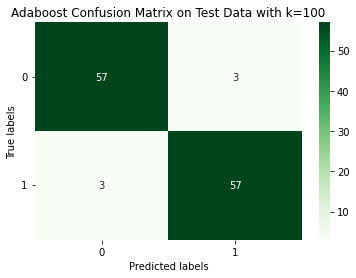

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix
def print_con_matrix(y,test_data_predictions):
        cm_svm =  confusion_matrix(y, test_data_predictions)

        ax = plt.subplot()
        import seaborn as sns
        sns.heatmap(cm_svm, annot=True, ax = ax, fmt='g', cmap='Greens') 

        # Labels, title and ticks
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels') 
        ax.set_title('Adaboost Confusion Matrix on Test Data with k=100') 
        labels = [0, 1]
        ax.xaxis.set_ticklabels(labels) 
        ax.yaxis.set_ticklabels(labels, rotation=360);

accuracy = accuracy_score(y_test.iloc[:,0],y_pred)
print("Accuracy on TestData",accuracy)
print_con_matrix(y_test.iloc[:,0],y_pred)